# Data analysis

This notebook analysis the `coinmarketcap.csv`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = 15,6

## Import code from *data preprocessing* notebook

In [3]:
import ipynb.fs  # Boilerplate required
# only import defnitions
from .defs.data_preprocessing import loadCoinMarketCap

## Load historical data into a dataframe

In [4]:
df = loadCoinMarketCap(
    minSamples   = 180, # only consider coins having at least half a year of samples
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
print(df.head())
print("Currencies: {}".format(", ".join(df[COL_NAME].unique())))

Samples filled: 5
Loaded 14 currencies, 11455 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: BTC, ETH, XRP, BCH, LTC, XLM, NEO, MIOTA, ETC, QTUM, EOS, TRX, USDT, SNT


In [5]:
# we are not interested in USDT, so remove it
df = df.loc[df[COL_NAME] != "USDT"]

## Plot currencies

First, get all **close** prices into a data frame.

In [6]:
dfClose = pd.DataFrame()
for col in df[COL_NAME].unique():
    series = df.loc[(df[COL_NAME] == col)][COL_CLOSE]
    series.rename(col, inplace=True)
    dfTmp = series.to_frame()
    dfTmp.reset_index(inplace=True)
    dfClose = dfTmp if dfClose.empty else pd.merge(dfClose, dfTmp, on="date", how="outer", sort=True)
dfClose = dfClose.set_index("date")
dfClose = dfClose[:].replace(0, np.nan) # replace 0 with np.nan, so it is not plotted

Nice go scatter plot function.

In [7]:
# https://blog.patricktriest.com/analyzing-cryptocurrencies-python/
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

Finally plot the graphs.

In [8]:
df_scatter(dfClose, title="Cryptocurrency Prices (USD)",
           seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

Calculate pearson correlation

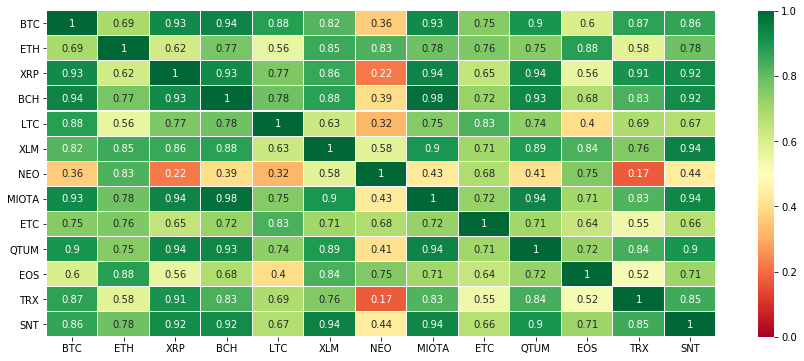

In [9]:
dfCorr = dfClose[dfClose.index.year >= 2018]
sns.heatmap(dfCorr.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
pass